In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-19 11:25:56.394099: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 11:25:56.397686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 11:25:56.458033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 11:25:56.459652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-19 11:25:57.410843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

In [3]:
# run PCA
# run GWAS and create dimensions
# save the dimensions
# cluster the dimensions

In [ ]:
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_projected/pop_0"
nr_of_projected_dimensions = 3
project_on_dimensions(path_input, path_output, nr_of_projected_dimensions)

# Observe raw dimensions

In [ ]:
"""
labels = silhouette_score_clusters(merged_df, ['dim_1', 'dim_2', 'dim_3'], plot=False)
merged_df['clusters'] = labels
make_population_plot(merged_df, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')
merged_df.to_pickle(f"{CONFIG['PATH_data']}/04_projected/samples_with_clusters.pkl")
"""

In [3]:
def project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10):
    path_output_to_do = f"{path_output}/to_do/"
    
    # Copy all contents from input to output to do
    for chrom in [f for f in os.listdir(path_macro_similar) if f.startswith("chrom")]:
        path_chrom = f"{path_macro_similar}/{chrom}"
        
        for chunk in [f for f in os.listdir(path_chrom) if f.startswith("chunk")]:
            path_chunk = f"{path_chrom}/{chunk}"
            geno = pd.read_pickle(path_chunk)
            geno = geno.loc[temp_ids['index']]
            os.makedirs(f"{path_output_to_do}/{chrom}/", exist_ok=True)
            geno.to_pickle(f"{path_output_to_do}/{chrom}/{chunk}")
    
    path_input = path_output
    path_input_to_do = f"{path_input}/to_do/"
    snp_ids = []
    
    for i in list(range(nr_of_projected_dimensions)):
        path_output_dim = f"{path_input}/dim_{i+1}/"
        os.makedirs(path_output_dim, exist_ok=True)
        PCs = pca_of_n_snps(path_input_to_do, path_output_dim, temp_ids, nr_snps, n_components)
        
        chroms = [f for f in os.listdir(path_input_to_do) if f.startswith('chrom')]
        
        for chrom in chroms:
            path_chrom = f"{path_input_to_do}/{chrom}"
            path_output_chrom = f"{path_output_dim}/{chrom}"
            os.makedirs(path_output_chrom, exist_ok=True)
            chunks = os.listdir(path_chrom)
            for chunk in chunks:
                path_chunk = f"{path_chrom}/{chunk}"
                path_chunk_raw = f"{path_macro_similar}/{chrom}/{chunk}"
                path_output_chunk = f"{path_output_chrom}/{chunk}"
                
                geno_raw = pd.read_pickle(path_chunk_raw)
                nr_snps_raw = geno_raw.shape[1]
                to_take = math.ceil(nr_snps_raw/nr_of_projected_dimensions)

                geno = pd.read_pickle(path_chunk)
                
                
                p_vals = []
                betas = []
                snps = []
                
                for snp in geno.columns:
                    [beta_values, p_values] = ols_regression(PCs['PC1'], geno[snp], covs=None)
                    p_vals.append(p_values[snp])
                    betas.append(beta_values[snp])
                    snps.append(snp)
                    
                p_vals = pd.DataFrame(data = {'pval': p_vals, 'betas':betas, 'snp_rs':snps})
                p_vals['-logp'] = -np.log10(p_vals['pval'].replace(0, 1e-300))
                
                # Assuming `p_vals` is a pandas DataFrame
                to_keep = p_vals.sort_values(by='-logp', ascending=False).head(to_take)
                to_keep['dim'] = i+1
                snp_ids.append(to_keep)
                
                # Filter out rows that are in `to_keep`
                to_do = p_vals.loc[~p_vals.index.isin(to_keep.index)]
                geno[to_keep['snp_rs']].to_pickle(path_output_chunk)
                geno[to_do['snp_rs']].to_pickle(path_chunk)
    
    snp_ids = pd.concat(snp_ids, axis=0)
    snp_ids.to_pickle(f"{path_output}/snp_ids.pkl")
    os.system(f"rm -rf {path_input_to_do}")

In [4]:
path_macro_similar = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

iterations = 3

path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"
ids = pd.read_pickle(f"{path_usefull}/ids.pkl")

for iter in list(range(iterations))[0:1]:
    print(f"Running iteration {iter}")
    path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    if iter == 0:
        ids[f"cluster_{iter}"] = 0
    else:
        pass
    
    cluster_to_add = []
    for sub_pop in ids[f"cluster_{iter}"].unique():
        path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/pop_{sub_pop}/"
        os.makedirs(path_output, exist_ok=True)
        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
        nr_of_projected_dimensions = 3
        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
        
        existing_dims = []   
        for dims in [f for f in os.listdir(path_output) if f.startswith('dim')]:
            PCs = pd.read_pickle(f"{path_output}/{dims}/global_PCs.pkl")
            temp_ids[dims] = PCs['PC1']
            existing_dims.append(dims)
        labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
        for element in labels:
            cluster_to_add.append(f"{sub_pop}_{element}")
            
    ids[f"cluster_{iter+1}"] = cluster_to_add

Running iteration 0
The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
ids = pd.read_pickle(f"{path_usefull}/ids.pkl")
ids

,FID,IID,PAT,MAT,SEX,PHENOTYPE,index
0,AFR,HG01879,0,0,1,-9,0
1,AFR,HG01880,0,0,2,-9,1
2,AFR,HG01882,0,0,1,-9,2
3,AFR,HG01883,0,0,2,-9,3
4,AFR,HG01885,0,0,1,-9,4
...,...,...,...,...,...,...,...
2499,SAS,NA21137,0,0,2,-9,2499
2500,SAS,NA21141,0,0,2,-9,2500
2501,SAS,NA21142,0,0,2,-9,2501
2502,SAS,NA21143,0,0,2,-9,2502


In [14]:
iteration = 0
path_input = f"{CONFIG['PATH_data']}/iteration_{iteration}/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_pop = f"{path_input}/{pop}"
    for dim in [f for f in os.listdir(path_pop) if f.startswith('dim')]:
        path_dim = f"{path_pop}/{dim}"
        PC_file = [f for f in os.listdir(path_dim) if f.startswith('global_PCs')][0]
        PCs = pd.read_pickle(f"{path_dim}/{PC_file}")
        ids[dim] = PCs['PC1']

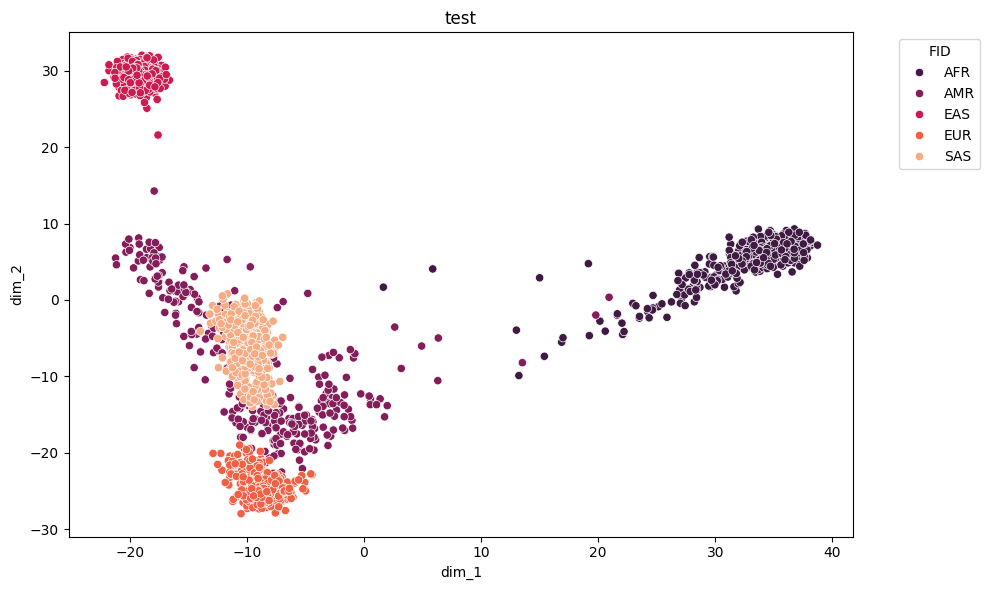

In [16]:
make_population_plot(ids, 'dim_1', 'dim_2', 'FID', 'test', palette = 'rocket')

In [5]:
path_input = f"{CONFIG['PATH_data']}/04_projected/pop_0/snp_ids.pkl"
pd.read_pickle(path_input)

,pval,betas,snp_rs,-logp,dim
139,3.394259e-82,-10.578245,rs10803434_A,81.469255,1
689,1.219847e-79,-10.456765,rs11802371_G,78.913694,1
18,8.948735e-67,9.651554,rs12743883_G,66.048238,1
321,8.137835e-66,-9.551678,rs4424509_G,65.089491,1
0,5.784439e-65,9.590214,rs3928804_T,64.237739,1
...,...,...,...,...,...
106,8.839202e-01,0.048281,rs1009059_C,0.053587,3
7,9.327122e-01,-0.023998,rs1894252_A,0.030252,3
102,9.587937e-01,0.016116,rs1974458_G,0.018275,3
137,9.846576e-01,-0.009442,rs2080729_T,0.006715,3


In [ ]:
path_input = f"{CONFIG['PATH_data']}/04_projected/pop_0"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    
make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation name', 'test', palette = 'rocket')

In [8]:
folders = os.listdir(f"{CONFIG['PATH_data']}")
os.makedirs(f"{CONFIG['PATH_data']}/09_snps_id/", exist_ok=True)
projected_folders = [folder for folder in folders if "projected" in folder]
i = 0
for folder in projected_folders:
    dfs = []
    path_projected = f"{CONFIG['PATH_data']}/{folder}"
    pops = [f for f in os.listdir(path_projected) if f.startswith('pop')]
    for pop in pops:
        path_pop = f"{path_projected}/{pop}"
        snp_id = [f for f in os.listdir(path_pop) if f.startswith('snp')][0]
        path_snp = f"{path_pop}/{snp_id}"
        temp = pd.read_pickle(path_snp)
        temp['pop'] = pop
        temp['folder'] = folder
        dfs.append(temp)
        
    dfs = pd.concat(dfs, axis=0)
    i = i + 1
    dfs.to_pickle(f"{CONFIG['PATH_data']}/09_snps_id/projection_{i}_ids.pkl")

In [10]:
path_projection_id = f"{CONFIG['PATH_data']}/09_snps_id/"
for projection_folder in [f for f in os.listdir(path_projection_id) if f.startswith('projection')]:
    projection = pd.read_pickle(f"{path_projection_id}/{projection_folder}")

In [ ]:
# Divide into chunks
"""
path_input  = f"{CONFIG['PATH_data']}/03_macro_similar_AF"
for cluster in list(merged_df['clusters'].unique()):
    cluster_df = merged_df[merged_df['clusters'] == cluster]
    for chrom in [f for f in os.listdir(path_input) if f.startswith('chrom')]:
        path_chrom = f"{path_input}/{chrom}"
        for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')]:
            path_chunk = f"{path_chrom}/{chunk}"
            chunk_df = pd.read_pickle(path_chunk)
            chunk_df['IID'] = ids['IID']
            merged = pd.merge(cluster_df[['IID']], chunk_df, on='IID')
            merged.drop('IID', axis=1, inplace=True)
            path_output = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/pop_{cluster}/{chrom}"
            os.makedirs(path_output, exist_ok=True)
            merged.to_pickle(f"{path_output}/{chunk}")
"""

'\npath_input  = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF"\nfor cluster in list(merged_df[\'clusters\'].unique()):\n    cluster_df = merged_df[merged_df[\'clusters\'] == cluster]\n    for chrom in [f for f in os.listdir(path_input) if f.startswith(\'chrom\')]:\n        path_chrom = f"{path_input}/{chrom}"\n        for chunk in [f for f in os.listdir(path_chrom) if f.startswith(\'chunk\')]:\n            path_chunk = f"{path_chrom}/{chunk}"\n            chunk_df = pd.read_pickle(path_chunk)\n            chunk_df[\'IID\'] = ids[\'IID\']\n            merged = pd.merge(cluster_df[[\'IID\']], chunk_df, on=\'IID\')\n            merged.drop(\'IID\', axis=1, inplace=True)\n            path_output = f"{CONFIG[\'PATH_data\']}/05_macro_similar_per_pop/pop_{cluster}/{chrom}"\n            os.makedirs(path_output, exist_ok=True)\n            merged.to_pickle(f"{path_output}/{chunk}")\n'

In [9]:
# iteration 1

In [11]:

"""
path_input = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/"
path_output = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_input_pop = f"{path_input}/{pop}"
    path_output_pop = f"{path_output}/{pop}"
    nr_of_projected_dimensions = 3
    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)
"""

'\npath_input = f"{CONFIG[\'PATH_data\']}/05_macro_similar_per_pop/"\npath_output = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\nfor pop in [f for f in os.listdir(path_input) if f.startswith(\'pop\')]:\n    path_input_pop = f"{path_input}/{pop}"\n    path_output_pop = f"{path_output}/{pop}"\n    nr_of_projected_dimensions = 3\n    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)\n'

In [ ]:
"""
merged_df = pd.read_pickle(f"{CONFIG['PATH_data']}/04_projected/pop_0/samples_with_clusters.pkl")
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:
    pop = int(pop.split('_')[1])
    temp_samples = merged_df[merged_df['clusters'] == pop].copy()
    path_pop = f"{path_input}/pop_{pop}"
    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]
    for dim in dims:
        path_dim = f"{path_pop}/{dim}"
        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
        path_PC = f"{path_dim}/{PCs}"
        PC_dim = pd.read_pickle(path_PC)
        temp_samples[dim] = list(PC_dim['PC1'])
    
    make_population_plot(temp_samples, 'dim_1', 'dim_2', 'Population name', 'test', palette = 'rocket')
    
    # clustering
    labels = silhouette_score_clusters(temp_samples, ['dim_1', 'dim_2', 'dim_3'], plot=False)
    temp_samples['clusters'] = labels
    temp_samples.to_pickle(f"{CONFIG['PATH_data']}/06_projected_per_pop/pop_{pop}/samples_with_clusters.pkl")
    make_population_plot(temp_samples, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')
"""

'\nmerged_df = pd.read_pickle(f"{CONFIG[\'PATH_data\']}/04_projected/samples_with_clusters.pkl")\npath_input = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n    pop = int(pop.split(\'_\')[1])\n    temp_samples = merged_df[merged_df[\'clusters\'] == pop].copy()\n    path_pop = f"{path_input}/pop_{pop}"\n    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]\n    for dim in dims:\n        path_dim = f"{path_pop}/{dim}"\n        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]\n        path_PC = f"{path_dim}/{PCs}"\n        PC_dim = pd.read_pickle(path_PC)\n        temp_samples[dim] = list(PC_dim[\'PC1\'])\n    \n    make_population_plot(temp_samples, \'dim_1\', \'dim_2\', \'Population name\', \'test\', palette = \'rocket\')\n    \n    # clustering\n    labels = silhouette_score_clusters(temp_samples, [\'dim_1\', \'dim_2\', \'dim_3\'], plot=False)\n    temp_samples[\

In [12]:
"""
path_input_macro  = f"{CONFIG['PATH_data']}/03_macro_similar_AF"
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:
    pop_nr = int(pop.split('_')[1])
    path_pop = f"{path_input}/{pop}"
    samples = pd.read_pickle(f"{path_pop}/samples_with_clusters.pkl")
    for cluster in list(samples['clusters'].unique()):
        cluster_df = samples[samples['clusters'] == cluster]
        
        for chrom in [f for f in os.listdir(path_input_macro) if f.startswith('chrom')]:
            path_chrom = f"{path_input_macro}/{chrom}"
            for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')]:
                path_chunk = f"{path_chrom}/{chunk}"
                chunk_df = pd.read_pickle(path_chunk)
                chunk_df['IID'] = ids['IID']
                merged = pd.merge(cluster_df[['IID']], chunk_df, on='IID')
                merged.drop('IID', axis=1, inplace=True)
                path_output = f"{CONFIG['PATH_data']}/07_macro_similar_per_sub_pop/pop_{pop_nr}_subpop_{cluster}/{chrom}"
                os.makedirs(path_output, exist_ok=True)
                merged.to_pickle(f"{path_output}/{chunk}")
                
"""

'\npath_input_macro  = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF"\npath_input = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n    pop_nr = int(pop.split(\'_\')[1])\n    path_pop = f"{path_input}/{pop}"\n    samples = pd.read_pickle(f"{path_pop}/samples_with_clusters.pkl")\n    for cluster in list(samples[\'clusters\'].unique()):\n        cluster_df = samples[samples[\'clusters\'] == cluster]\n        \n        for chrom in [f for f in os.listdir(path_input_macro) if f.startswith(\'chrom\')]:\n            path_chrom = f"{path_input_macro}/{chrom}"\n            for chunk in [f for f in os.listdir(path_chrom) if f.startswith(\'chunk\')]:\n                path_chunk = f"{path_chrom}/{chunk}"\n                chunk_df = pd.read_pickle(path_chunk)\n                chunk_df[\'IID\'] = ids[\'IID\']\n                merged = pd.merge(cluster_df[[\'IID\']], chunk_df, on=\'IID\')\n                merged

In [13]:
"""
path_input = f"{CONFIG['PATH_data']}/07_macro_similar_per_sub_pop/"
path_output = f"{CONFIG['PATH_data']}/08_projected_per_sub_pop/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_input_pop = f"{path_input}/{pop}"
    path_output_pop = f"{path_output}/{pop}"
    nr_of_projected_dimensions = 3
    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)
    
"""

'\npath_input = f"{CONFIG[\'PATH_data\']}/07_macro_similar_per_sub_pop/"\npath_output = f"{CONFIG[\'PATH_data\']}/08_projected_per_sub_pop/"\nfor pop in [f for f in os.listdir(path_input) if f.startswith(\'pop\')]:\n    path_input_pop = f"{path_input}/{pop}"\n    path_output_pop = f"{path_output}/{pop}"\n    nr_of_projected_dimensions = 3\n    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)\n    \n'

In [7]:
"""
path_propjected = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
path_input = f"{CONFIG['PATH_data']}/08_projected_per_sub_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:

    sub_pop = int(pop.split('_')[3])
    pop = int(pop.split('_')[1])
    
    path_propjected_pop = f"{path_propjected}/pop_{pop}"
    merged_df = pd.read_pickle(f"{path_propjected_pop}/samples_with_clusters.pkl")
    temp_samples = merged_df[merged_df['clusters'] == sub_pop].copy()
    path_pop = f"{path_input}/pop_{pop}_subpop_{sub_pop}"
    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]
    for dim in dims:
        path_dim = f"{path_pop}/{dim}"
        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
        path_PC = f"{path_dim}/{PCs}"
        PC_dim = pd.read_pickle(path_PC)
        temp_samples[dim] = list(PC_dim['PC1'])
    
    make_population_plot(temp_samples, 'dim_3', 'dim_2', 'Population name', 'test', palette = 'rocket')
"""

'\npath_propjected = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npath_input = f"{CONFIG[\'PATH_data\']}/08_projected_per_sub_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n\n    sub_pop = int(pop.split(\'_\')[3])\n    pop = int(pop.split(\'_\')[1])\n    \n    path_propjected_pop = f"{path_propjected}/pop_{pop}"\n    merged_df = pd.read_pickle(f"{path_propjected_pop}/samples_with_clusters.pkl")\n    temp_samples = merged_df[merged_df[\'clusters\'] == sub_pop].copy()\n    path_pop = f"{path_input}/pop_{pop}_subpop_{sub_pop}"\n    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]\n    for dim in dims:\n        path_dim = f"{path_pop}/{dim}"\n        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]\n        path_PC = f"{path_dim}/{PCs}"\n        PC_dim = pd.read_pickle(path_PC)\n        temp_samples[dim] = list(PC_dim[\'PC1\'])\n    \n    make_population_plot(temp_samples, \'dim_3\', \'dim_2\', \'Populat

# Find perfect MAF prediction

In [49]:
"""
folders = os.listdir(f"{CONFIG['PATH_data']}")
os.makedirs(f"{CONFIG['PATH_data']}/09_snps_id/", exist_ok=True)
projected_folders = [folder for folder in folders if "projected" in folder]
i = 0
for folder in projected_folders:
    dfs = []
    path_projected = f"{CONFIG['PATH_data']}/{folder}"
    pops = [f for f in os.listdir(path_projected) if f.startswith('pop')]
    for pop in pops:
        path_pop = f"{path_projected}/{pop}"
        snp_id = [f for f in os.listdir(path_pop) if f.startswith('snp')][0]
        path_snp = f"{path_pop}/{snp_id}"
        temp = pd.read_pickle(path_snp)
        temp['pop'] = pop
        temp['folder'] = folder
        dfs.append(temp)
        
    dfs = pd.concat(dfs, axis=0)
    i = i + 1
    dfs.to_pickle(f"{CONFIG['PATH_data']}/09_snps_id/projection_{i}_ids.pkl")
"""

'\nfolders = os.listdir(f"{CONFIG[\'PATH_data\']}")\nos.makedirs(f"{CONFIG[\'PATH_data\']}/09_snps_id/", exist_ok=True)\nprojected_folders = [folder for folder in folders if "projected" in folder]\ni = 0\nfor folder in projected_folders:\n    dfs = []\n    path_projected = f"{CONFIG[\'PATH_data\']}/{folder}"\n    pops = [f for f in os.listdir(path_projected) if f.startswith(\'pop\')]\n    for pop in pops:\n        path_pop = f"{path_projected}/{pop}"\n        snp_id = [f for f in os.listdir(path_pop) if f.startswith(\'snp\')][0]\n        path_snp = f"{path_pop}/{snp_id}"\n        temp = pd.read_pickle(path_snp)\n        temp[\'pop\'] = pop\n        temp[\'folder\'] = folder\n        dfs.append(temp)\n        \n    dfs = pd.concat(dfs, axis=0)\n    i = i + 1\n    dfs.to_pickle(f"{CONFIG[\'PATH_data\']}/09_snps_id/projection_{i}_ids.pkl")\n'

In [ ]:
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
projection_ids = os.listdir(f"{CONFIG['PATH_data']}/09_snps_id/")

for chrom in [f for f in  os.listdir(path_input) if f.startswith('chrom')][0:1]:
    path_chrom = f"{path_input}/{chrom}"
    for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')][0:1]:
        path_chunk = f"{path_chrom}/{chunk}"
        chunk_df = pd.read_pickle(path_chunk)
        for snp in list(chunk_df.columns)[0:3]:     
            for projection_id in projection_ids:
                path_projection = f"{CONFIG['PATH_data']}/09_snps_id/{projection_id}"
                projection = pd.read_pickle(path_projection)
                snps_folders = projection[projection['snp_rs'] == snp].sort_values('pop')
                
                
                


yey rs3928804_T
rs3928804_T
yey rs6695244_A
rs6695244_A
yey rs12745158_G
rs12745158_G


In [51]:
snps_folders

,pval,betas,snp_rs,-logp,dim,pop,folder
2,0.403572,-0.429250,rs12745158_G,0.394079,2,pop_0_subpop_0,08_projected_per_sub_pop
2,0.184803,2.707016,rs12745158_G,0.733292,1,pop_0_subpop_1,08_projected_per_sub_pop
2,0.271207,1.207662,rs12745158_G,0.566698,2,pop_0_subpop_2,08_projected_per_sub_pop
2,0.058531,5.270240,rs12745158_G,1.232614,1,pop_1_subpop_0,08_projected_per_sub_pop
2,0.222673,-1.315814,rs12745158_G,0.652333,2,pop_1_subpop_1,08_projected_per_sub_pop
1,0.422229,1.603859,rs12745158_G,0.374452,2,pop_1_subpop_2,08_projected_per_sub_pop
2,0.133921,1.403120,rs12745158_G,0.873152,1,pop_1_subpop_3,08_projected_per_sub_pop
1,0.392363,0.876370,rs12745158_G,0.406312,2,pop_2_subpop_0,08_projected_per_sub_pop
2,0.090999,3.384176,rs12745158_G,1.040963,1,pop_2_subpop_1,08_projected_per_sub_pop
1,0.451859,-0.525493,rs12745158_G,0.344997,3,pop_2_subpop_2,08_projected_per_sub_pop


In [ ]:
# Assuming df is your DataFrame
for index, row in snps_folders.iterrows():
    pop = row['pop']
    dim = row['dim']
    folder = row['folder']
    path_projected = f"{CONFIG['PATH_data']}/{folder}/{pop}/dim_{dim}/"

In [62]:
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
AFs = pd.read_pickle(path_usefull)


In [64]:
AFs[AFs['snp_rs'] == snp]

,snp_rs,AF,RSID,POS,CHROM
1363,rs12745158_G,0.5,rs12745158,39802413,1


In [61]:
snp_id[snp_id['snp_rs'] == snp]

,pval,betas,snp_rs,-logp,dim
2,0.317308,2.297452,rs12745158_G,0.498519,2
